In [6]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils
import matplotlib
from matplotlib import pyplot as plt
import numpy as np


In [7]:
# 랜덤 요소를 고정하는 시드를 정합니다. 자유롭게 바꿔도 괜찮습니다.
seed = 2023

# Colab 환경의 T4 GPU를 사용하기 위해 설정합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [8]:
# 데이터셋을 구성합니다.
train_dataset = datasets.MNIST(
    root = "./mnist/",
    train = True,
    transform = transforms.Compose([
        transforms.ToTensor(), # PIL 이미지를 [0-1] 사이 tensor로 변환해줍니다.
        transforms.Resize(64), # 이미지 크기를 64x64로 바꿔줍니다.
        transforms.Normalize(.5, .5), # 픽셀 값을 0.5를 빼고 0.5로 나눠줍니다 --> tensor 범위 [-1,1]
    ]),
    download = True)

test_dataset = datasets.MNIST(
    root = "./mnist/",
    train = False,
    transform = transforms.Compose([
        transforms.ToTensor(), # PIL 이미지를 [0-1] 사이 tensor로 변환해줍니다.
        transforms.Resize(64), # 이미지 크기를 64x64로 바꿔줍니다.
        transforms.Normalize(.5, .5), # 픽셀 값을 0.5를 빼고 0.5로 나눠줍니다 --> tensor 범위 [-1,1]
    ]),
    download = True)

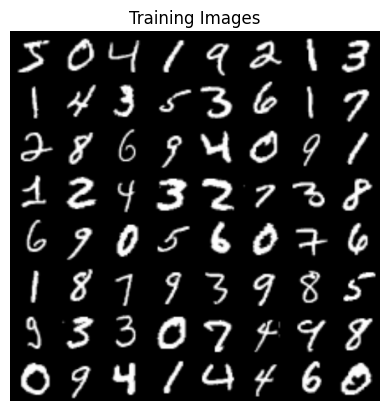

In [9]:
"""
64개 이미지 그려보기
1. train_dataset[idx][0]: 해당 idx의 이미지 (64x64 tensor)
2. unsqueeze(0): 이미지 차원을 1x1x64x64로 바꿈
3. torch.cat: 64개의 tensor를 합쳐 64x1x64x64 크기의 tensor로 만듦
4. torchvision.utils.make_grid: 1x296x296 크기의 np.ndarray로 바꿔줌 (normalize=True: 이미지를 [0,1] 범위로 바꿔줌)
5. np.transpose: plt.imshow 함수는 입력으로 WxHxC 순서의 데이터를 받으므로 296x296x1 크기로 transpose
"""
plt.axis('off')
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(torch.cat([train_dataset[i][0].unsqueeze(0) for i in range(64)], dim=0), normalize=True), (1,2,0)))

In [10]:
"""
생성 모델
arguments:
    latent_dim: 잠재 변수의 차원
    out_channels: 출력 이미지의 채널 개수
    base_channels: 전치 합성곱 신경망의 기본 채널 크기
"""
class Generator(nn.Module):
    def __init__(self,
                 latent_dim: int=64,
                 base_channels: int=64,
                 out_channels: int=1):

        # nn.Module의 __init__ 함수를 먼저 호출해줍니다
        super().__init__()

        self.model = nn.Sequential(
            # 입력: latent_dim x 1 x 1 크기
            nn.ConvTranspose2d(latent_dim, base_channels*8, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(base_channels*8), # 채널 단위로 정규화를 해줍니다
            nn.ReLU(inplace=True),
            # (base_channels*8) x 4 x 4 크기
            nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(inplace=True),
            # (base_channels*4) x 8 x 8 크기
            nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(inplace=True),
            # (base_channels*2) x 16 x 16 크기
            nn.ConvTranspose2d(base_channels*2, base_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            # (base_channels) x 32 x 32 크기
            nn.ConvTranspose2d(base_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # 1 x 64 x 64 크기
        )

    def forward(self, z):
        return self.model(z)

판별자 구현